# BPMN Process Generation

We generated 10 BPMN processes for each combination of maximum nested XOR and maximum independent XOR, ranging from 1 to 10. This resulted in a total of 1000 unique processes (10 x 10 x 10). The generation process follows these general steps:

1. Start with a seed string '_', which represents a single task.

2. Iteratively replace underscores with one of three possible structures:
   - XOR split: `(_ ^ _)`
   - Parallel split: `(_ || _)`
   - Sequential: `(_ , _)`

3. The replacement process continues until the desired complexity (in terms of nested and independent XORs) is achieved.

4. Finally, replace remaining underscores with task labels (T1, T2, etc.).

The generation process uses weighted random choices to determine which structure to use for each replacement. This allows for controlled variability in the generated processes.

Key aspects of the generation:

- The `replace_random_underscore` function (in `random_diagram_generation.py`) performs the core replacement logic.
- Probabilities for each type of replacement can be specified or randomly generated using `guess_three_numbers` (in `random_diagram_generation.py`).
- The `max_nested_xor` and `max_independent_xor` functions (in `stats.py`) are used to evaluate the complexity of the generated processes.
- The `generate_multiple_processes` function (in `random_batch_generation.py`) manages the overall generation process, ensuring the desired number of processes with specific complexities are created.

This approach ensures a diverse set of BPMN processes with varying levels of complexity, suitable for thorough testing and analysis of process-related algorithms.

Using probabilities: (0.08987866468713546, 0.7438100147440796, 0.16631132056878495)
Generated Process:
((((T1 || T2) || T3) , T4) || (((T5 ^ ((T6 ^ T7) ^ T8)) ^ (T9 || T10)) || T11))

Max Nested XOR: 4
Max Independent XOR: 1

Process Diagram:


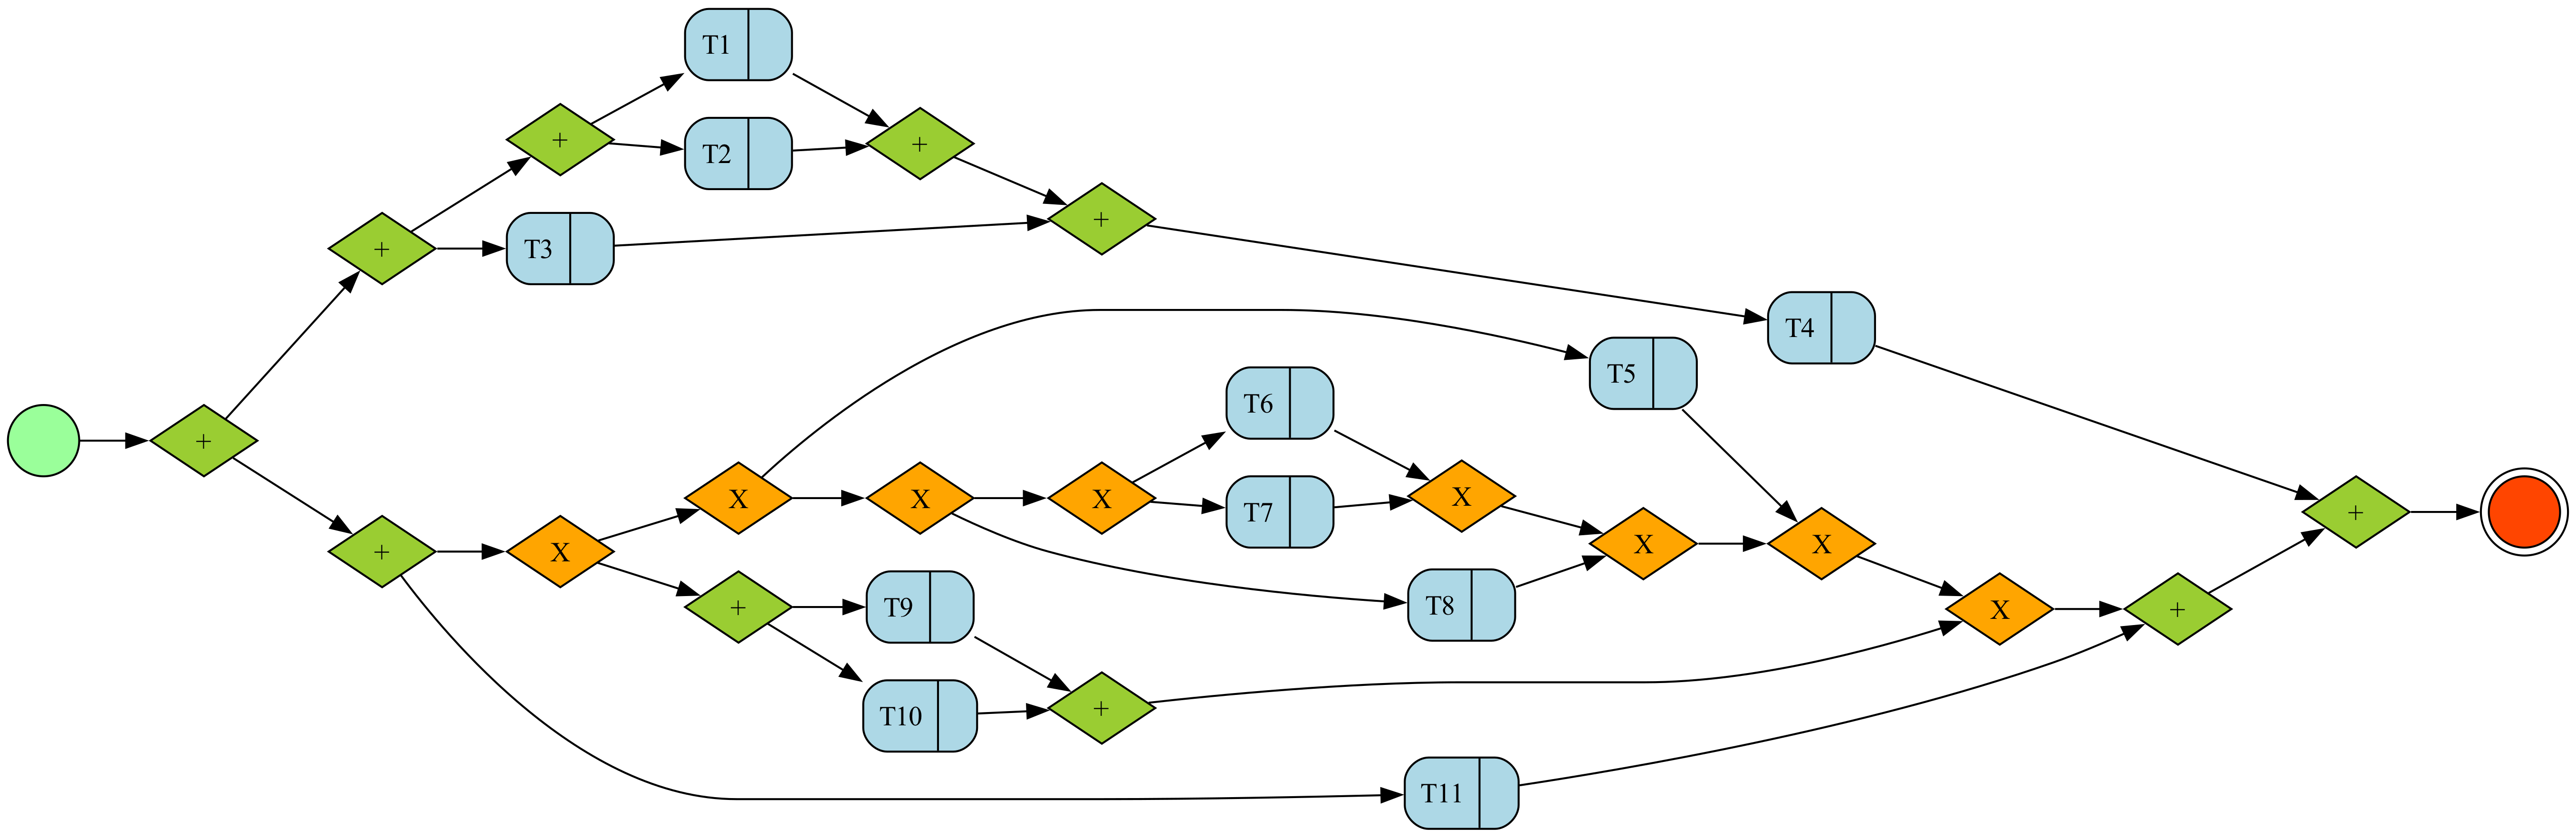

In [1]:
# Import necessary functions and modules
from random_diagram_generation import SEED_STRING, replace_random_underscore, replace_underscores, guess_three_numbers
from sese_diagram import PARSER, print_sese_diagram, print_tree, dot_tree
from stats import max_nested_xor, max_independent_xor

# Generate a process
current_string = SEED_STRING
probabilities = guess_three_numbers()
print(f"Using probabilities: {probabilities}")

iterations = 10
for _ in range(iterations):
    current_string = replace_random_underscore(current_string, probabilities)

process = replace_underscores(current_string)
print("Generated Process:")
print(process)

# Parse the process
tree = PARSER.parse(process)

# Print process statistics
print(f"\nMax Nested XOR: {max_nested_xor(process)}")
print(f"Max Independent XOR: {max_independent_xor(process)}")

# Visualize the process
print("\nProcess Diagram:")
print_sese_diagram(process)



Process Tree:


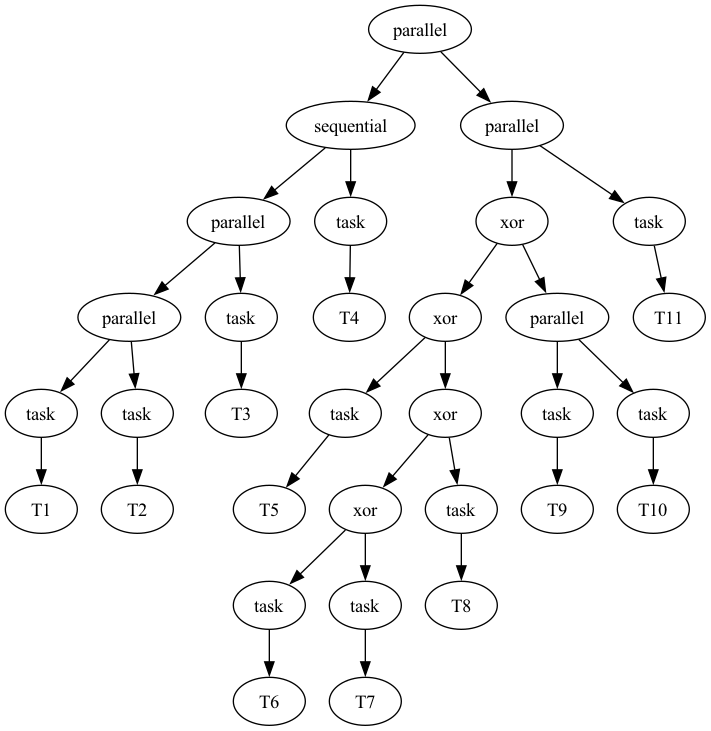

In [2]:

# Print the parse tree
print("\nProcess Tree:")
print_tree(dot_tree(tree)[0])

# Impact Vector Generation

After generating the BPMN processes, we create a set of impact vectors for each process. These impact vectors represent the multi-dimensional effects or outcomes of the tasks within each process. We use six different modes to generate these vectors, each providing a unique distribution of values. The impact vectors are generated using functions from `generate_impacts.py`.

## Generation Modes

1. **Random**: 
   - Generates vectors where each dimension is a random value between 0 and 1.
   - No further modifications are made to these vectors.

2. **Bagging Divide**: 
   - Starts with random vectors (values between 0 and 1).
   - Randomly selects dimensions and divides their values by 10.
   - This creates vectors with a mix of larger (original) and smaller (divided) impacts.

3. **Bagging Remove**: 
   - Starts with random vectors (values between 0 and 1).
   - Randomly selects dimensions and sets their values to 0.
   - The result is a sparse vector where some dimensions have no impact.

4. **Bagging Remove Divide**: 
   - Starts with random vectors (values between 0 and 1).
   - Randomly selects dimensions and sets their values to 0.
   - For the non-zero dimensions, randomly selects some and divides their values by 10.
   - This creates sparse vectors with a mix of original and reduced non-zero values.

5. **Bagging Remove Reverse**: 
   - Starts with random vectors (values between 0 and 1).
   - Creates a new vector of zeros with the same dimension.
   - Randomly selects dimensions from the original vector and copies their values to the new vector.
   - This results in a sparse vector where the non-zero values retain their original magnitudes and positions.

6. **Bagging Remove Reverse Divide**: 
   - Starts with random vectors (values between 0 and 1).
   - Creates a new vector of zeros with the same dimension.
   - Randomly selects dimensions from the original vector and copies their values to the new vector.
   - Among the non-zero values in the new vector, randomly selects some and divides them by 10.
   - This creates a sparse vector with a mix of original and reduced non-zero values in their original positions.

## Process

For each BPMN process:
1. We determine the number of tasks in the process.
2. We generate a set of impact vectors equal to the number of tasks, using one of the six modes described above.
3. The dimension of each vector corresponds to the number of impact factors being considered (ranging from 1 to 10 in our experiments).
4. These vectors are then associated with the tasks in the process in order of appearance.

For example, if a process has 5 tasks, we generate 5 impact vectors using the chosen mode. Then we assign these vectors to the tasks in the order they appear in the process description.

## Dimension Range

In our experiments, we generate impact vectors with dimensions varying from 1 to 10. This range allows us to analyze how the number of impact factors affects the complexity and performance of our algorithms.

## Association with Tasks

The association of impact vectors with tasks is done by creating a dictionary where:
- The keys are the task identifiers (e.g., "T1", "T2", "T3", etc.)
- The values are the corresponding generated impact vectors

This dictionary is then used in subsequent analyses to retrieve the impact vector for any given task in the process.

By using these diverse generation modes, varying dimensions, and associating vectors with specific tasks, we create a comprehensive dataset that captures a wide range of possible impact distributions across different process structures. This approach enables thorough testing and analysis of our process impact evaluation algorithms across different scenarios and complexities.


Process Diagram with Impact Vectors (truncated to 2 decimal places):


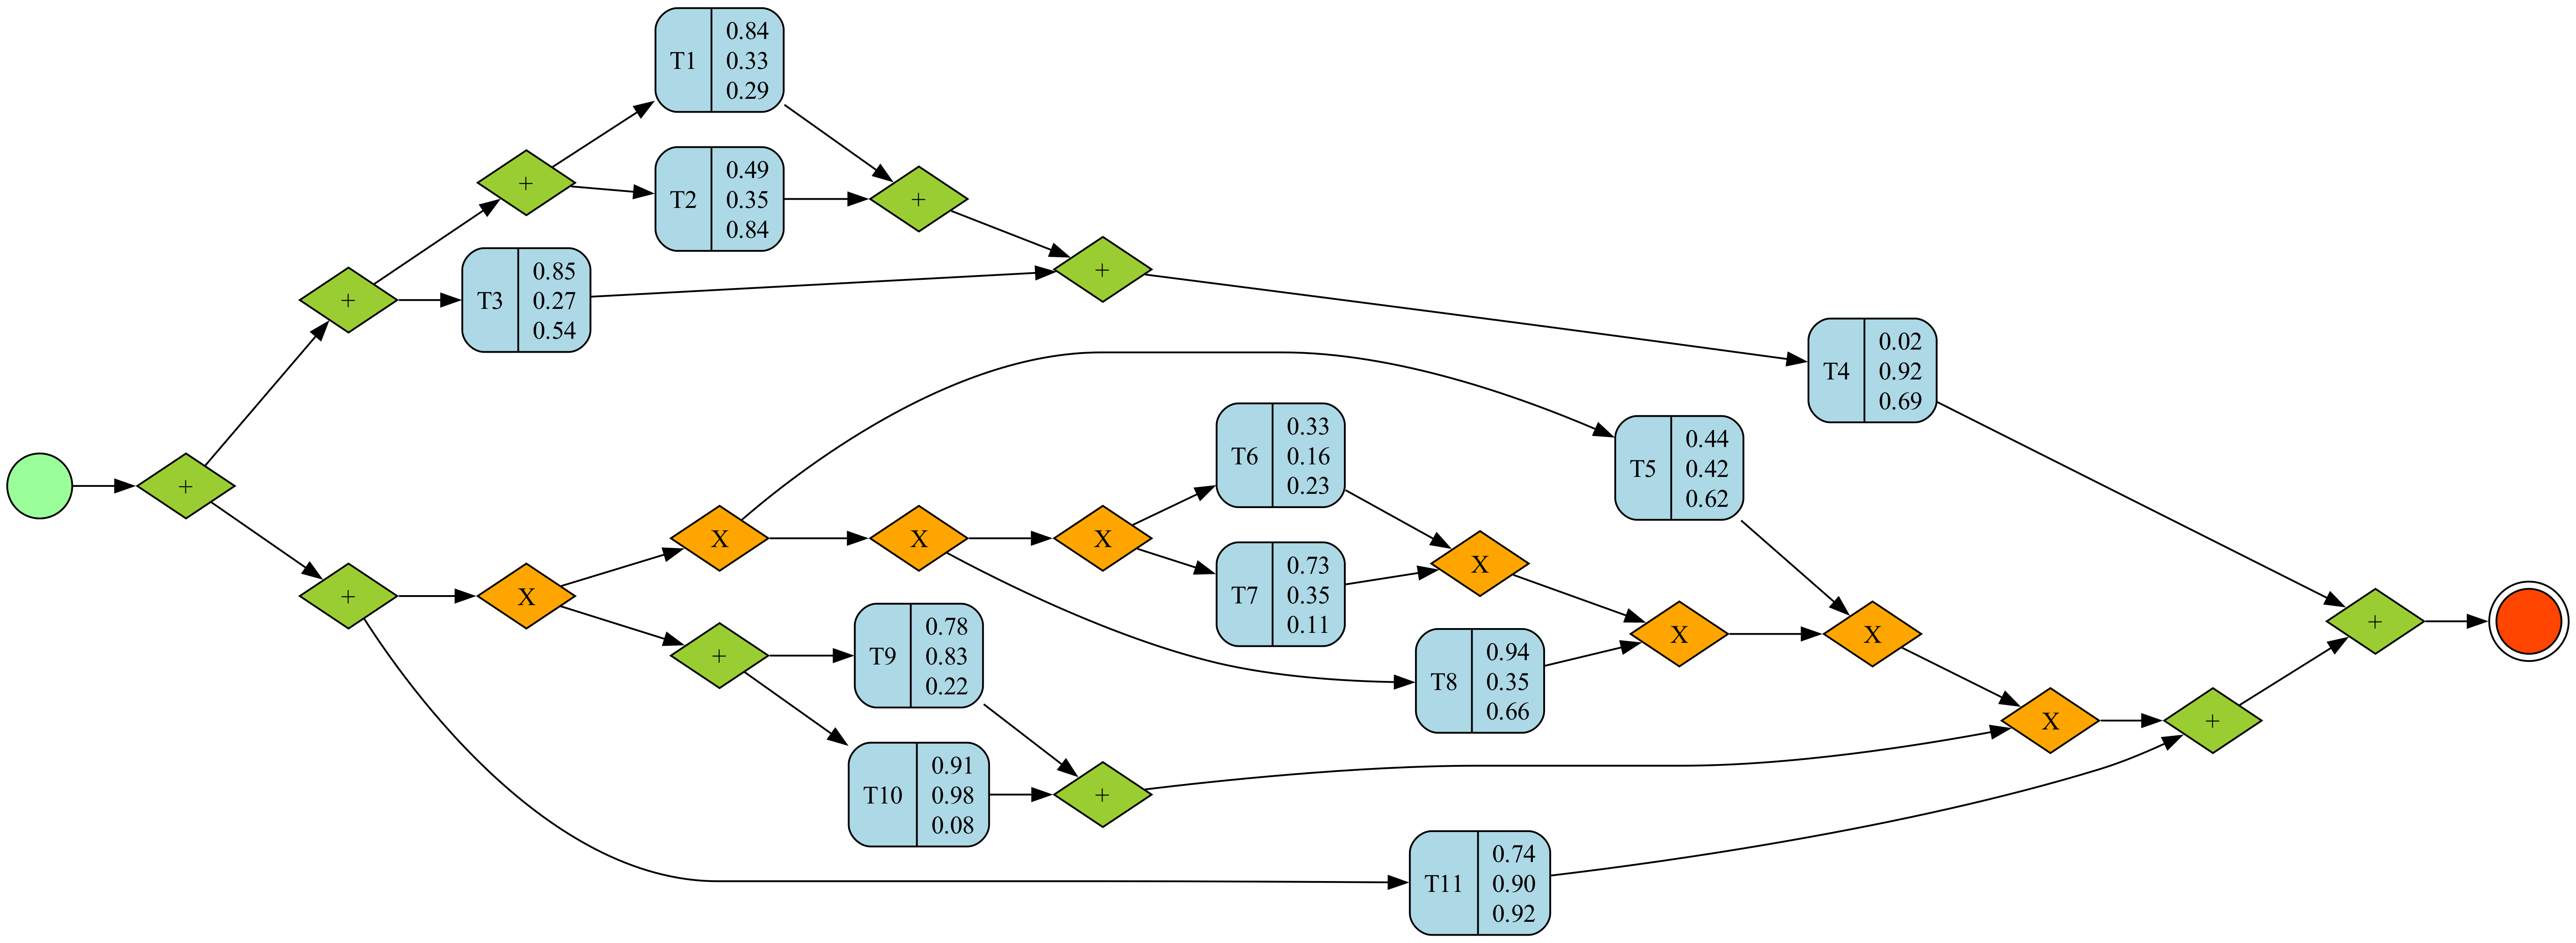

In [3]:
from generate_impacts import generate_vectors
from utils import find_max_task_number


num_tasks = find_max_task_number(process)
dimension = 3 

vectors = generate_vectors(num_tasks, dimension, mode="random")  # You can change the mode as needed

impacts = {f"T{i+1}": vector.tolist() for i, vector in enumerate(vectors)}

print("\nProcess Diagram with Impact Vectors (truncated to 2 decimal places):")
print_sese_diagram(process, impacts=impacts, impacts_names=[f"Impact {i+1}" for i in range(dimension)])

# Vector Generation and Analysis Process

To analyze the characteristics of our impact vector generation methods, we will conduct a comprehensive study across different dimensions and generation modes. This process will help us understand how the different generation modes affect the distribution and relationships between the vectors.

## Process Overview

1. **Vector Generation**: 
   - For each dimension (1 to 10) and each of the six generation modes, we will generate 100 vectors.
   - This results in 60 sets of 100 vectors each (10 dimensions × 6 modes).

2. **Cosine Distance Calculation**:
   - For each set of 100 vectors, we will compute the cosine distance between each pair of vectors.
   - The cosine distance is calculated as:

     $\text{cosine\_distance}(A, B) = 1 - \frac{A \cdot B}{\|A\| \|B\|}$

   where $A \cdot B$ is the dot product of vectors A and B, and $\|A\|$ and $\|B\|$ are the magnitudes of vectors A and B respectively.

   - **Important Note**: Since all our generated vectors contain only non-negative values, the cosine distance will always be between 0 and 1. This is because:
     - The dot product of two non-negative vectors is always non-negative.
     - The magnitudes of non-negative vectors are always positive.
     - Therefore, the fraction $\frac{A \cdot B}{\|A\| \|B\|}$ is always between 0 and 1.
     - Subtracting this fraction from 1 gives us a distance that is also between 0 and 1.

3. **Statistical Analysis**:
   - For each set of cosine distances (4950 distances per set, as there are $\binom{100}{2} = 4950$ pairs in 100 vectors), we will compute:
     - The mean cosine distance
     - The standard deviation of the cosine distances

4. **Visualization**:
   - We will create a scatter plot to visualize the results:
     - X-axis: Dimensions (1 to 10)
     - Y-axis: Mean cosine distance
     - Error bars: Representing the standard deviation, clamped to the [0, 1] range
     - Different colors and symbols for each generation mode

## Generation Modes

We will use the following six modes for vector generation, in this order:

1. Random
2. Bagging Divide
3. Bagging Remove
4. Bagging Remove Divide
5. Bagging Remove Reverse
6. Bagging Remove Reverse Divide

## Expected Insights

This analysis will allow us to:
- Understand how the different generation modes affect the similarity/dissimilarity between vectors.
- Observe how the dimensionality of the vectors impacts the distances between them.
- Identify which generation modes produce more diverse or more similar sets of vectors.
- Determine how the variability in distances changes across dimensions and generation modes.

These insights will be crucial for selecting appropriate vector generation methods for different scenarios in our BPMN process impact analysis. The bounded nature of our cosine distances, between 0 and 1 since we allow positive vectors, provides a consistent scale for comparing the different modes and dimensions.

In [20]:
%run impact_stats.py

# Run the analysis and plot the results
generate_and_analyze_vectors(num_vectors=100, max_dim=10)
plot_mean_std_intervals_by_dimension(results, modes)

Analyzing modes: 100%|██████████| 6/6 [00:00<00:00,  7.67it/s]
